This is from:
https://github.com/FarisNolan/Neural_Algorithm_Artistic_Style/blob/master/N_A_A_S.py

In [28]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 27 08:33:31 2018
@author: Faris
"""


'\nCreated on Thu Dec 27 08:33:31 2018\n@author: Faris\n'

In [29]:
#-----IMPORTS AND DIRECTORIES-----
import time
import os 

In [30]:
image_dir = 'images/'
model_dir = 'model/'

In [31]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [32]:
import torchvision
from torchvision import transforms

In [33]:
from PIL import Image
from collections import OrderedDict

In [34]:
import matplotlib.pyplot as plt

In [35]:
#CAN RETURN OUTPUT FROM ANY LAYER
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #CONV LAYERS
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        #HANDLE POOLING OPTIONS
        #MAX POOLING
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #AVERAGE POOLING
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool3 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool4 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool5 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            
        #FORWARD PROP
    def forward(self, x, out_keys):
        out = {}
        
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        
        
        #RETURN DESIRED ACTIVATIONs
        return [out[key] for key in out_keys]


In [36]:
#----------------------------------------------------    
#-----COMPUTING GRAM MATRIX AND GRAM MATRIX LOSS-----.0
#----------------------------------------------------
            
#GRAM MATRICES ARE USED TO MEASURE STYLE LOSS
#MATRIX
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, w, h = input.size()
        F = input.view(b, c, h * w)
        #COMPUTES GRAM MATRIX BY MULTIPLYING INPUT BY TRANPOSE OF ITSELF
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h*w)
        return G

#LOSS
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out
    

In [37]:
img_size = 256

#PRE-PROCESSING
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]), #CONVERT TO BGR FOR VGG NET
                           transforms.Normalize(mean = [0.40760392, 0.45795686, 0.48501961], std = [1, 1, 1]), #SUBTRACT IMAGENET MEAN
                           transforms.Lambda(lambda x: x.mul_(255)), #VGG WAS TRAINED WITH PIXEL VALUES 0-255
])

In [38]:

#POST PROCESSING A
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                            transforms.Normalize(mean = [-0.40760392, -0.45795686, -0.48501961], std = [1, 1, 1]),
                            transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),    
        ])

In [39]:
#POST PROCESSING B
postpb = transforms.Compose([transforms.ToPILImage()])

#POST PROCESSING FUNCTION INCORPORATES A AND B, AND CLIPS PIXEL VALUES WHICH ARE OUT OF RANGE
def postp(tensor):
    t = postpa(tensor)
    t[t>1] = 1
    t[t<0] = 0
    img = postpb(t)
    return img


In [40]:
#---------------------------          
#-----PREPARING NETWORK-----
#--------------------------- 
    
vgg = VGG()

vgg.load_state_dict(torch.load(model_dir + 'vgg_conv_weights.pth'))            
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [41]:
#-----LOADING AND PREPARING IMAGES-----
img_dirs = [image_dir, image_dir]

In [42]:
#----------------------------
#-----SETUP FOR TRAINING-----
#----------------------------
#LAYERS FOR STYLE AND CONTENT LOSS
style_layers = ['r11', 'r12', 'r31', 'r41', 'r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers


In [43]:
#CREATING LOSS FUNCTION
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns] 

In [44]:
#SETUP WEIGHTS FOR LOSS LAYERS
style_weights = [1e3/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e0]
weights = style_weights + content_weights

Loop starts here

In [45]:
# #IMAGE LOADING ORDER: STYLE, CONTENT
# # img_names = ['style_vandrie_yellow_forest.jpg', 'content_rocky_lake.jpg']
# # img_names = ['style_monet_sunset.jpg', 'content_tree.jpg' ]
# # img_names = ['style_monet_sunset.jpg', 'content_evening_city.jpg' ]
# # img_names = ['style_group7_moutains.jpg', 'content_evening_city.jpg' ]
# img_names = ['style_vandrie_yellow_forest.jpg', 'content_tree.jpg']

# imgs = [Image.open(img_dirs[i] + name) for i, name in enumerate(img_names)]
# imgs_torch = [prep(img) for img in imgs]

In [46]:
def style_content_images():
    img_names = ['style_vandrie_yellow_forest.jpg', 'content_tree.jpg']

    imgs = [Image.open(img_dirs[i] + name) for i, name in enumerate(img_names)]
    imgs_torch = [prep(img) for img in imgs]
    return imgs_torch

# imgs_torch = style_content_images()

In [47]:
# #HANDLE CUDA
# if torch.cuda.is_available():
#     imgs_torch = [Variable(img.unsqueeze(0)).cuda() for img in imgs_torch]
# else:
#     imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
# style_img, content_img = imgs_torch
# # for img in imgs_torch:
# #   print("Image size: ", img.size())

In [48]:
def imgs_cuda(imgs_torch):
    #HANDLE CUDA
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0)).cuda() for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_img, content_img = imgs_torch
    return style_img, content_img

# style_img, content_img = imgs_cuda(imgs_torch)

In [49]:
def optimizable_img(content_img):
    #SET UP IMAGE TO BE OPTIMIZED
    #CAN BE INITIALIZED RANDOMLY OR AS A CLONE OF CONTENT IMAGE, AS DONE BELOW
    opt_img = Variable(content_img.clone(), requires_grad = True)
    return opt_img
# opt_img = optimizable_img(content_img)

In [50]:
# #SET UP IMAGE TO BE OPTIMIZED
# #CAN BE INITIALIZED RANDOMLY OR AS A CLONE OF CONTENT IMAGE, AS DONE BELOW
# opt_img = Variable(content_img.clone(), requires_grad = True)
# # print(content_img.size())
# # print(opt_img.size())

# # #DISPLAY IMAGES
# # for img in imgs:
# #     plt.grid(None)
# #     plt.imshow(img)
# #     plt.show()

In [51]:
# #CREATE OPTIMIZATION TARGETS
# style_targets = [GramMatrix()(A).detach() for A in vgg(style_img, style_layers)]
# content_targets = [A.detach() for A in vgg(content_img, content_layers)]
# targets = style_targets + content_targets


In [52]:
def optimization_targets(style_img, style_layers, content_img, content_layers):
    #CREATE OPTIMIZATION TARGETS
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_img, style_layers)]
    content_targets = [A.detach() for A in vgg(content_img, content_layers)]
    targets = style_targets + content_targets
    return targets

# targets = optimization_targets(style_img, style_layers, content_img, content_layers)

In [53]:
def load_images_and_setup(style_layers, content_layers):
    imgs_torch = style_content_images()
    style_img, content_img = imgs_cuda(imgs_torch)
    opt_img = optimizable_img(content_img)
    targets = optimization_targets(style_img, style_layers, content_img, content_layers)
    return opt_img, style_img, content_img, targets

In [54]:
opt_img, style_img, content_img, targets = load_images_and_setup(style_layers, content_layers)

In [55]:
#-----------------------
#-----TRAINING LOOP-----
#-----------------------
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img])
print(opt_img.size())
print(content_img.size())
n_iter = [0]

#ENTER LOOP
while n_iter[0] <= max_iter:
  
    def closure():
        optimizer.zero_grad()
        
        #FORWARD
        out = vgg(opt_img, loss_layers)
        
        #LOSS
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        
        #BACKWARDS
        loss.backward()
        
        #TRACK PROGRESS
        n_iter[0] += 1
        if n_iter[0] % show_iter == (show_iter - 1):
            print('Iteration: %d,\tLoss: %f' % (n_iter[0] + 1, loss.data.item()))
            
        return loss
    
    optimizer.step(closure)

torch.Size([1, 3, 256, 409])
torch.Size([1, 3, 256, 409])
Iteration: 50,	Loss: 10305498.000000
Iteration: 100,	Loss: 4349463.000000
Iteration: 150,	Loss: 2937036.000000
Iteration: 200,	Loss: 2294835.000000
Iteration: 250,	Loss: 1897011.000000
Iteration: 300,	Loss: 1635394.250000
Iteration: 350,	Loss: 1481304.500000
Iteration: 400,	Loss: 1393031.750000
Iteration: 450,	Loss: 1333766.750000
Iteration: 500,	Loss: 1287487.125000


409.0
409.0
409.0


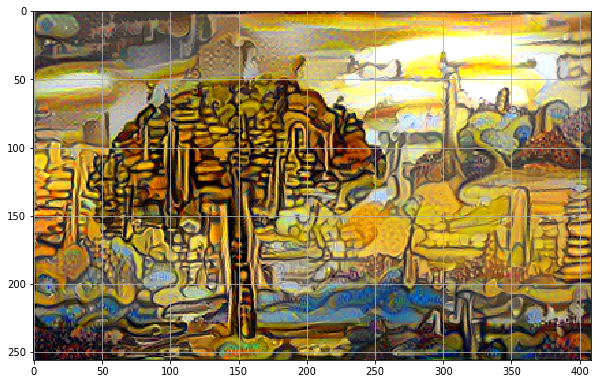

In [56]:
#-----------------
#-----RESULTS-----
#-----------------
print(float(opt_img.size(3)))
print(float(content_img.size(3)))
out_img = postp(opt_img.data[0].cpu().squeeze())
print(float(prep(out_img).size(2)))
plt.grid(None)
plt.imshow(out_img)
plt.gcf().set_size_inches(10, 10)

In [108]:
out_img.save('city_group7_mountain_style.png')